In [ ]:
!pip install yfinance scikit-learn matplotlib seaborn keras --quiet

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
import seaborn as sns

In [30]:
start = '2018-01-01'
end = '2023-12-31'
stock = 'TSLA'   # Change to BTC-USD, ETH-USD etc. for crypto
n_lookback = 60

In [31]:
data = yf.download(stock, start=start, end=end)
data.reset_index(inplace=True)
print("Sample Data:\n", data.head())

/tmp/ipython-input-31-2470538552.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Sample Data:
 Price        Date      Close       High        Low       Open     Volume
Ticker                  TSLA       TSLA       TSLA       TSLA       TSLA
0      2018-01-02  21.368668  21.474001  20.733334  20.799999   65283000
1      2018-01-03  21.150000  21.683332  21.036667  21.400000   67822500
2      2018-01-04  20.974667  21.236668  20.378668  20.858000  149194500
3      2018-01-05  21.105333  21.149332  20.799999  21.108000   68868000
4      2018-01-08  22.427334  22.468000  21.033333  21.066668  147891000


In [32]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']

In [33]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features])

In [34]:
X, y = [], []
for i in range(n_lookback, len(data_scaled)):
    X.append(data_scaled[i - n_lookback:i, 3])  # Using Close price (index 3)
    y.append(data_scaled[i, 3])
X, y = np.array(X), np.array(y)

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [35]:
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (1159, 60, 1)
X_test shape: (290, 60, 1)


In [37]:
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(n_lookback, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [39]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop])

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0476 - val_loss: 0.0099
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss

In [41]:
y_pred_scaled = model.predict(X_test)
dummy_pred = np.zeros((len(y_pred_scaled), 5))
dummy_actual = np.zeros((len(y_test), 5))

dummy_pred[:, 3] = y_pred_scaled.flatten()
dummy_actual[:, 3] = y_test

y_pred = scaler.inverse_transform(dummy_pred)[:, 3]
y_actual = scaler.inverse_transform(dummy_actual)[:, 3]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [44]:
print("\n Model Evaluation:")
print("MSE:", mean_squared_error(y_actual, y_pred))
print("MAE:", mean_absolute_error(y_actual, y_pred))
print("R² Score:", r2_score(y_actual, y_pred))


 Model Evaluation:
MSE: 159.27531074831936
MAE: 10.04816624186431
R² Score: 0.9153420973664399


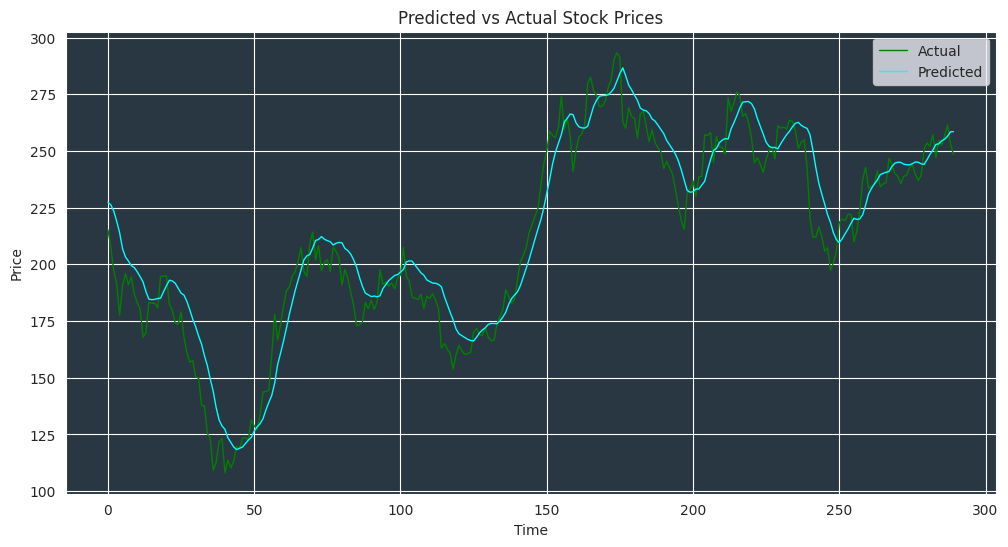

In [52]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
plt.plot(y_actual, label='Actual',color='green', linewidth=1)
plt.plot(y_pred, label='Predicted',color='cyan', linewidth=1)
plt.title('Predicted vs Actual Stock Prices')
plt.gca().set_facecolor('#293742')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [53]:
model.save("stock_model.keras")